# Loading packages

In [13]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras as keras
from tensorflow.data import TextLineDataset, Dataset
from tensorflow.io import read_file, decode_png
from pathlib import Path
import sys, os, yaml
from os.path import join
sys.path.append("/wecare/home/khoi/thesis")
from utils.data_path import *
import metrics
from glob import glob
from model_2Du_net import UNet
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.math import equal
from importlib import reload
from Unet_utils import threshold_binarize, process
from sklearn.metrics import precision_score, recall_score
from PIL import Image
import cv2
from tqdm import tqdm
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [57]:
reload(metrics)

<module 'metrics' from '/wecare/home/khoi/thesis/models/2d_unet/metrics.py'>

# Loading data

## Yaml config parse 

In [1]:
def parse_config(yaml_config):
    """
    Parse a yaml config file to return a list of absolute file path to train+val text files. Also return absolute path to test set.
    This function makes the assumption that there is only one path to test set and it's a whole directory, not a text file.
    """
    with open(yaml_config, "r") as f:
        yaml_dict = yaml.safe_load(f)
    
    data_root = Path(yaml_dict["path"])
    train_paths = []
    val_paths = []
    for train_rel, val_rel in zip(yaml_dict["train"], yaml_dict["val"]):
        train_paths.append(str(data_root / train_rel))
        val_paths.append(str(data_root / val_rel))
    test_paths = str(data_root / yaml_dict["test"][0])
    return train_paths, val_paths, test_paths

In [40]:
train_paths, val_paths, test_paths = parse_config("scratch_holdout_1.yaml")

In [4]:
train_paths, val_paths, test_paths

(['/wecare/home/khoi/thesis/ct_processed_aug/images/fold_2_train.txt',
  '/wecare/home/khoi/thesis/ct_processed_aug/images/fold_3_train.txt',
  '/wecare/home/khoi/thesis/ct_processed_aug/images/fold_4_train.txt',
  '/wecare/home/khoi/thesis/ct_processed_aug/images/fold_5_train.txt'],
 ['/wecare/home/khoi/thesis/ct_processed_aug/images/fold_2_val.txt',
  '/wecare/home/khoi/thesis/ct_processed_aug/images/fold_3_val.txt',
  '/wecare/home/khoi/thesis/ct_processed_aug/images/fold_4_val.txt',
  '/wecare/home/khoi/thesis/ct_processed_aug/images/fold_5_val.txt'],
 '/wecare/home/khoi/thesis/ct_processed_aug/images/fold_1')

## Load data into TextLineDataset/Dataset

In [57]:
train_ds = TextLineDataset(train_paths)
val_ds = TextLineDataset(val_paths)
test_ds = Dataset.list_files(test_paths + "/*")
#test_ds = keras.utils.image_dataset_from_directory(color_mode = "grayscale", image_size = (192, 192))

In [64]:
test_ds.cardinality().numpy()

13011

In [53]:
for x in test_ds.take(3):
    print(x)

tf.Tensor(b'/wecare/home/khoi/thesis/ct_processed_aug/images/fold_1/CTP42_001_0144.png', shape=(), dtype=string)
tf.Tensor(b'/wecare/home/khoi/thesis/ct_processed_aug/images/fold_1/CTP55_001_0197_aug09.png', shape=(), dtype=string)
tf.Tensor(b'/wecare/home/khoi/thesis/ct_processed_aug/images/fold_1/CTP69_001_0542.png', shape=(), dtype=string)


In [54]:
for i, element in enumerate(train_ds.as_numpy_iterator()):
    if i > 3:
        break
    print(element)

b'./fold_2/CTP22_001_0271_aug09.png'
b'./fold_2/CTP07_001_0220.png'
b'./fold_2/CTP22_001_0249.png'
b'./fold_2/CTP70_001_0123_aug00.png'


To do: <br>
    - Create traing images and targets <br>
    - Create validation images and targets <br>
    - Create test images and targets <br>

# Split data

In [67]:
# ~/thesis/runs/yolov5/detect/holdout_1/fold_2/crops/lesion
holdout = 1
IMG_DIR = str(Path(YOLOV5_DETECT) / f"holdout_{holdout}")
MASK_DIR = str(Path(YOLOV5_DETECT) / f"holdout_{holdout}_true")

In [69]:
train_val_list = glob(join(IMG_DIR, f"fold_[!{holdout}]*/crops/lesion/*"))
train_list, val_list = train_test_split(train_val_list, test_size = 0.2, random_state = 99)

In [70]:
len(train_list), len(val_list)

(23926, 5982)

In [71]:
train_ds = tf.data.Dataset.from_tensor_slices(train_list)
val_ds = tf.data.Dataset.from_tensor_slices(val_list)
test_ds = Dataset.list_files(join(IMG_DIR, f"fold_{holdout}/crops/lesion/*"))
train_ds.cardinality().numpy(), val_ds.cardinality().numpy(), test_ds.cardinality().numpy()

(23926, 5982, 2795)

In [12]:
def process(mask_dir,  x):
    """
    Process the path of the original image. Take out the fold number and image ID. Then process it
    to create a proper path for 2D U-Net training, val or testing. Return a pair of image, one for
    cropped image and cropped mask.
    --------------------
    Parameters:
    
    mask_dir: Directory that contains all the cropped true masks. For example, /wecare/home/khoi/thesis/runs/yolov5/detect/holdout_1_true
    x: absolute path to the image
    """
    splits = tf.strings.split(x, sep = os.sep)
    fold, img_id = splits[-4], tf.strings.split(splits[-1], sep = ".")[0]
    img_path = x
    mask_path = tf.strings.join([tf.constant(mask_dir, dtype = tf.string),fold, "crops/lesion",img_id + '.png'], separator = os.sep)

    img = decode_png(read_file(img_path), channels = 1)
    mask = decode_png(read_file(mask_path), channels = 1)
    #img = tf.image.resize(img, [192, 192], method = "nearest")
    #mask = tf.image.resize(mask, [192, 192], method = "nearest")
    mask = tf.cast(equal(mask, 255), tf.float32)
    return img, mask

In [73]:
train_ds = train_ds.map(lambda x: process(MASK_DIR, x))
val_ds = val_ds.map(lambda x: process(MASK_DIR, x))
test_ds = test_ds.map(lambda x: process(MASK_DIR, x))

In [8]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size = 1000)
    ds = ds.batch(64, drop_remainder = True)
    ds = ds.prefetch(buffer_size = tf.data.AUTOTUNE)
    return ds

In [9]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

In [ ]:
for img, mask in val_ds.as_numpy_iterator():
    print(img.shape, mask.shape)

In [22]:
for img, mask in val_ds.take(1):
    #print(keras.layers.LayerNormalization(axis = -2)(img)[0][:10])
    print(img.shape, mask.shape)

(64, 192, 192, 1) (64, 192, 192, 1)


2022-06-06 19:50:28.240894: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [147]:
for img, mask in train_ds.take(1):
    img0 = img
    mask0 = mask

2022-06-06 00:33:55.984113: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [137]:
model.evaluate(train_ds)

374/374 [==============================] - 16s 42ms/step - loss: 0.7188 - dice_coef: 0.4687


[0.7188180088996887, 0.4686797857284546]

In [72]:
inputs = tf.keras.layers.Input((192, 192, 1))
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
model_ = keras.Model(inputs = [inputs], outputs = [c1])
model_.predict(img0).shape

(64, 192, 192, 16)

In [133]:
foo_pred = model.predict(img0)

In [87]:
higher_threshold_indices = foo_pred > 0.5
lower_threshold_indices = foo_pred <= 0.5
foo_pred[higher_threshold_indices] = 1
foo_pred[lower_threshold_indices] = 0
foo_pred[0,:3,:3,0]

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32)

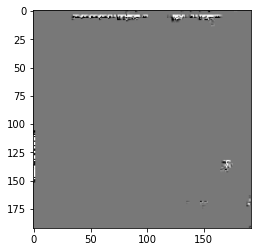

In [134]:
plt.imshow(foo_pred[0], cmap = plt.gray())

In [148]:
foo_pred_bin = tf.cast(foo_pred > 0.5, tf.float32)
mask_flatten = keras.backend.flatten(mask0)
pred_flatten = keras.backend.flatten(foo_pred_bin)
tf.math.reduce_sum(mask_flatten * pred_flatten)

<tf.Tensor: shape=(), dtype=float32, numpy=9144.0>

# Define training loop

In [10]:
BATCH_SIZE = 64
EPOCHS = 3
INIT_LR = 1e-4
MAX_LR = 1e-2

In [11]:
steps_per_epoch = len(train_ds) // BATCH_SIZE
lr_schedule = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=2 * steps_per_epoch,
)
loss_func = keras.losses.BinaryCrossentropy()
optimizer = keras.optimizers.Adam(lr_schedule)
checkpoint_cb = keras.callbacks.ModelCheckpoint("runs/holdout_1/best_model.h5", monitor = "val_dice_coef", mode = "max", save_freq = 'epoch', save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 20, restore_best_weights = True)
callbacks = [checkpoint_cb, early_stopping_cb]

In [27]:
def train_model(model, train_ds, val_ds, loss_func, optimizer, metrics, callbacks, batch_size, epochs):
    model.compile(loss= loss_func, optimizer=optimizer,
                       metrics= metrics)
    history = model.fit( x = train_ds,
        batch_size=batch_size,
        validation_data= val_ds,
        epochs=epochs, callbacks = callbacks)
    return history

In [28]:
model = UNet(192, 192, 1, 16, 0.2)
model.load_weights("Weights_0.h5")

In [29]:
history = train_model(
            model = model,
            train_ds=train_ds,
            val_ds=val_ds,
            loss_func=loss_func,
            optimizer=optimizer,
            metrics=[metrics.dice_coef],
            callbacks=callbacks,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS)

Epoch 1/3
Tensor("Sum_2:0", shape=(), dtype=float32)
Tensor("Sum_2:0", shape=(), dtype=float32)


2022-06-06 19:50:56.343876: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


373/373 [==============================] - ETA: 0s - loss: 4.2746 - dice_coef: 0.4973y_pred: (64, 192, 192, 1)
Tensor("Sum_2:0", shape=(), dtype=float32)
373/373 [==============================] - 62s 151ms/step - loss: 4.2746 - dice_coef: 0.4973 - val_loss: 0.6932 - val_dice_coef: 0.5121
Epoch 2/3
373/373 [==============================] - 54s 145ms/step - loss: 0.6924 - dice_coef: 0.5166 - val_loss: 0.6919 - val_dice_coef: 0.5213
Epoch 3/3
373/373 [==============================] - 54s 144ms/step - loss: 0.6919 - dice_coef: 0.5227 - val_loss: 0.6917 - val_dice_coef: 0.5250


2022-06-06 19:58:27.688653: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


# Evaluation

In [7]:
test_ds = test_ds.batch(1)

In [8]:
def scale_fn(x):
    return 1/(2.**(x-1))

In [12]:
BATCH_SIZE = 64
EPOCHS = 3
INIT_LR = 1e-4
MAX_LR = 1e-2

steps_per_epoch = len(train_ds) // BATCH_SIZE
lr_schedule = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=2 * steps_per_epoch,
)
loss_func = keras.losses.BinaryCrossentropy()
optimizer = keras.optimizers.Adam(lr_schedule)

In [9]:
model = keras.models.load_model("runs/holdout_1/best_model_binEntropy.h5", custom_objects = {"dice_coef" : metrics.dice_coef}, compile = False)
#model.compile(loss= loss_func, optimizer=optimizer, metrics= [metrics.dice_coef])

In [14]:
model.evaluate(test_ds)

y_pred: (None, 192, 192, 1)
Tensor("Sum_2:0", shape=(), dtype=float32)
y_pred: (None, 192, 192, 1)
Tensor("Sum_2:0", shape=(), dtype=float32)


2022-06-15 16:47:12.405839: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


2795/2795 [==============================] - 22s 7ms/step - loss: 0.0401 - dice_coef: 0.3833


[0.040101196616888046, 0.3832705616950989]

In [10]:
y_pred = model.predict(test_ds)

2022-06-19 17:31:52.753594: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


In [36]:
y_test = np.zeros(y_pred.shape)
x_test = np.zeros(y_pred.shape)
max_i = 0
metric_accumulate = np.zeros(len(test_ds))
for i, (img, mask) in enumerate(test_ds.as_numpy_iterator()):
    y_pred = model.predict(img)
    
    higher_threshold_indices = y_pred > 0.5
    lower_threshold_indices = y_pred <= 0.5
    y_pred[higher_threshold_indices] = 1
    y_pred[lower_threshold_indices] = 0
    
    metric_accumulate[i] = metrics.dice_coef(mask.astype(np.float32), y_pred).numpy()
#print(metric_accumulate.shape)
print(np.mean(metric_accumulate))

0.4875780640269993


In [15]:
higher_threshold_indices = y_pred > 0.5
lower_threshold_indices = y_pred <= 0.5
y_pred[higher_threshold_indices] = 1
y_pred[lower_threshold_indices] = 0

In [21]:
metrics.dice_coef(y_test.astype(np.float32), y_pred).numpy()

tf.Tensor(372412.0, shape=(), dtype=float32)


0.25512424

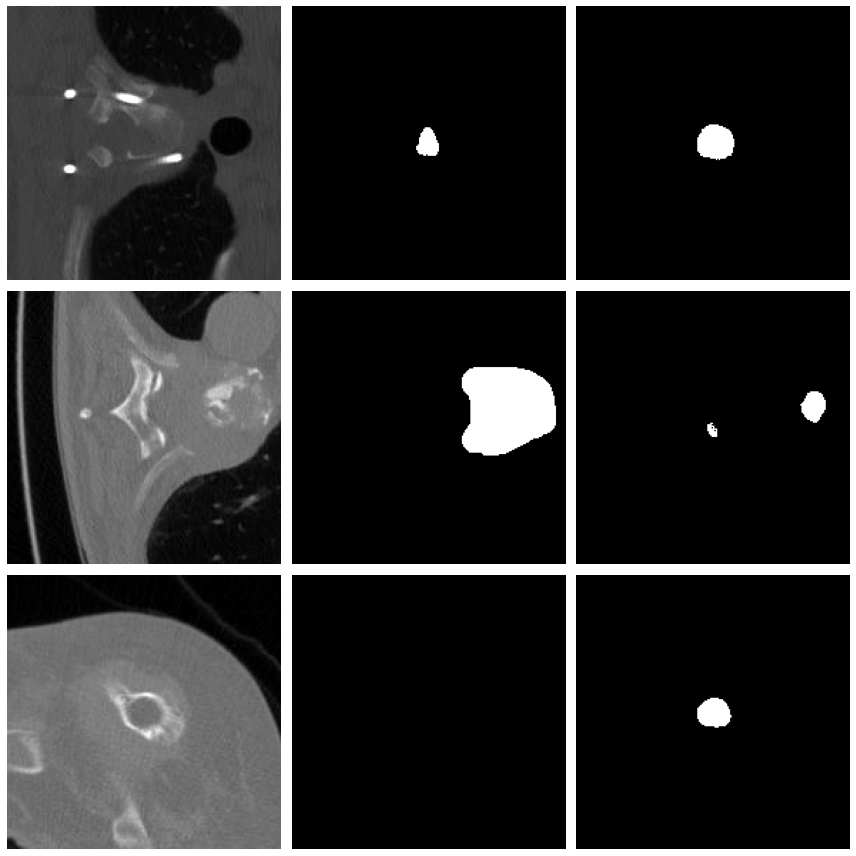

In [21]:
fig, axs = plt.subplots(3,3, figsize = (12, 12))
[axi.set_axis_off() for axi in axs.ravel()]
fig.tight_layout()
for i, (img, mask) in enumerate(test_ds.as_numpy_iterator()):
    if i < 3:
        y_pred = threshold_binarize(model.predict(img), 0.5)
        axs[i,0]
        axs[i, 0].imshow(np.squeeze(img), cmap = plt.gray())
        axs[i, 1].imshow(np.squeeze(mask), cmap = plt.gray())
        axs[i, 2].imshow(np.squeeze(y_pred), cmap = plt.gray())

In [22]:
fig.savefig(Path(ROOT) / "figures/2D_Unet" / "sample_ImgMaskSeg", format = "png", facecolor = "white", dpi = 300)

# Analysis

In [ ]:
# ~/thesis/runs/yolov5/detect/holdout_1/fold_2/crops/lesion
holdout = 1
IMG_DIR = str(Path(YOLOV5_DETECT) / f"holdout_{holdout}")
MASK_DIR = str(Path(YOLOV5_DETECT) / f"holdout_{holdout}_true")

In [ ]:
test_ds = Dataset.list_files(join(IMG_DIR, f"fold_{holdout}/crops/lesion/*"))
test_ds = test_ds.map(lambda x: process(MASK_DIR, x))

In [7]:
"""
Row: prec < 0.5, prec > 0.5, prec > 0.7
Col: recall < 0.5, recall > 0.5, recall > 0.7
"""

count_arr = np.zeros((5,3,3))
for holdout in tqdm(range(1,6)):
    model = keras.models.load_model(f"runs/holdout_{holdout}/best_model_binEntropy.h5", custom_objects = {"dice_coef" : metrics.dice_coef}, compile = False)
    IMG_DIR = str(Path(YOLOV5_DETECT) / f"holdout_{holdout}")
    MASK_DIR = str(Path(YOLOV5_DETECT) / f"holdout_{holdout}_true")
    test_ds = Dataset.list_files(join(IMG_DIR, f"fold_{holdout}/crops/lesion/*")).map(lambda x: process(MASK_DIR, x)).batch(1)
    ds_size = len(test_ds)
    for i, (img, mask) in enumerate(test_ds.as_numpy_iterator()):
        y_pred = threshold_binarize(model.predict(img), 0.5)
        img, mask, y_pred = cv2.cvtColor(np.squeeze(img), cv2.COLOR_GRAY2RGB), cv2.cvtColor(np.squeeze(mask), cv2.COLOR_GRAY2RGB), cv2.cvtColor(np.squeeze(y_pred), cv2.COLOR_GRAY2RGB)
        # Color prediction with red
        img[(y_pred == 1.0).all(-1)] = [255, 0, 0]
        # Color true mask with blueb
        img[(mask == 1.0).all(-1)] = [0, 0, 255]
        prec, recall = metrics.prec_recal(mask, y_pred)
        
        if prec < 0.5:
            if recall < 0.5:
                count_arr[holdout - 1, 0, 0] += 1
            elif 0.5 < recall < 0.7:
                count_arr[holdout - 1, 0, 1] += 1
            elif recall > 0.7:
                count_arr[holdout - 1, 0, 2] += 1
        elif 0.5 < prec < 0.7:
            if recall < 0.5:
                count_arr[holdout - 1, 1, 0] += 1
            elif 0.5 < recall < 0.7:
                count_arr[holdout - 1, 1, 1] += 1
            elif recall > 0.7:
                count_arr[holdout - 1, 1, 2] += 1
        elif prec > 0.7:
            if recall < 0.5:
                count_arr[holdout - 1, 2, 0] += 1
            elif 0.5 < recall < 0.7:
                count_arr[holdout - 1, 2, 1] += 1
            elif recall > 0.7:
                count_arr[holdout - 1, 2, 2] += 1
        
    count_arr[holdout - 1, :, :] /= ds_size

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [30:40<00:00, 368.04s/it]


In [9]:
np.mean(count_arr, axis = 0)

array([[0.25188283, 0.00694828, 0.02254671],
       [0.0073031 , 0.00965142, 0.03691866],
       [0.0647321 , 0.10012786, 0.49769659]])

In [10]:
np.std(count_arr, axis = 0)

array([[0.06131391, 0.00795632, 0.02304146],
       [0.0044734 , 0.0040141 , 0.02013422],
       [0.03789349, 0.05095493, 0.15301534]])

# Visualisation

In [74]:
test_ds = test_ds.batch(1)

(192, 192, 3) (192, 192, 3)
(192, 192, 3) (192, 192, 3)
(192, 192, 3) (192, 192, 3)


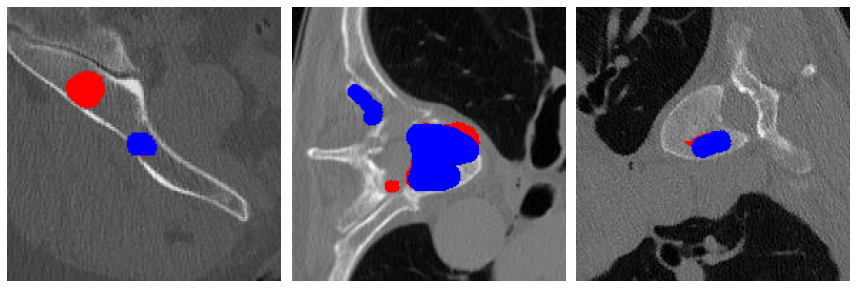

In [55]:
"""
Row: prec < 0.5, prec > 0.5, prec > 0.7
Col: recall < 0.5, recall > 0.5, recall > 0.7
"""
fig, axs = plt.subplots(1,3, figsize = (12, 12))
[axi.set_axis_off() for axi in axs.ravel()]
fig.tight_layout()
imgs_list = np.zeros()
masks_list = []
for i, (img, mask) in enumerate(test_ds.as_numpy_iterator()):
    if i < 3:
        y_pred = threshold_binarize(model.predict(img), 0.5)
        img, mask, y_pred = cv2.cvtColor(np.squeeze(img), cv2.COLOR_GRAY2RGB), cv2.cvtColor(np.squeeze(mask), cv2.COLOR_GRAY2RGB), cv2.cvtColor(np.squeeze(y_pred), cv2.COLOR_GRAY2RGB)
        # Color prediction with red
        img[(y_pred == 1.0).all(-1)] = [255, 0, 0]
        # Color true mask with blueb
        img[(mask == 1.0).all(-1)] = [0, 0, 255]
        axs[i].imshow(np.squeeze(img), cmap = plt.gray())

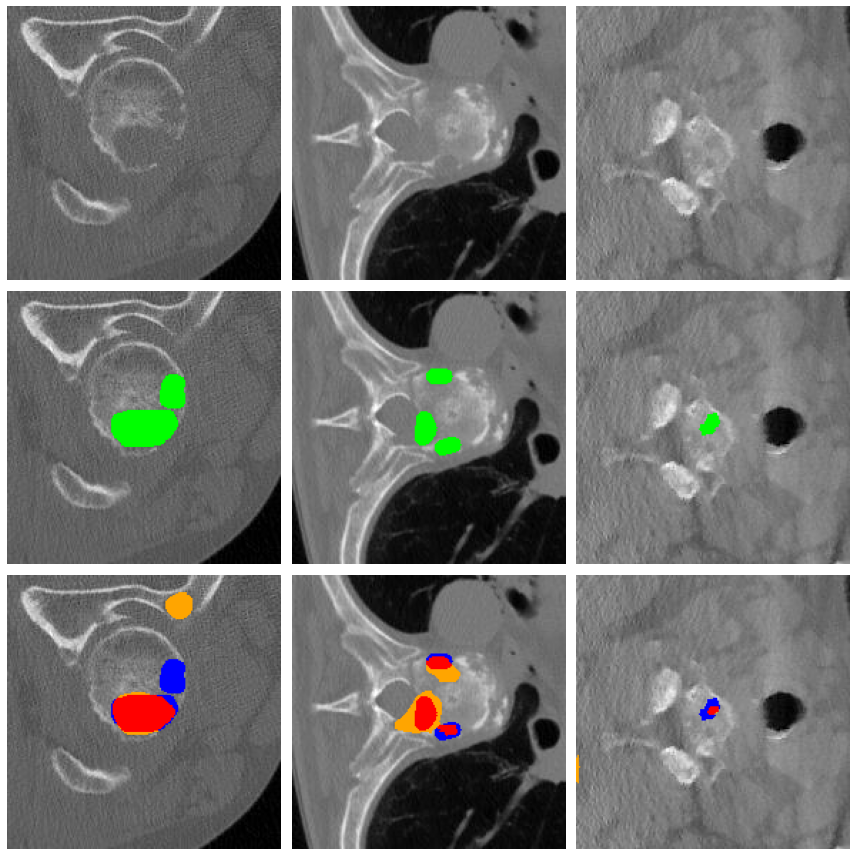

In [126]:
"""
Row: prec < 0.5, prec > 0.5, prec > 0.7
Col: recall < 0.5, recall > 0.5, recall > 0.7
"""
fig, axs = plt.subplots(3,3, figsize = (12, 12))
[axi.set_axis_off() for axi in axs.ravel()]
fig.tight_layout()
for i, (img, mask) in enumerate(test_ds.as_numpy_iterator()):
    if i < 3:
        y_pred = threshold_binarize(model.predict(img), 0.5)
        img, mask, y_pred = cv2.cvtColor(np.squeeze(img), cv2.COLOR_GRAY2RGB), cv2.cvtColor(np.squeeze(mask), cv2.COLOR_GRAY2RGB), cv2.cvtColor(np.squeeze(y_pred), cv2.COLOR_GRAY2RGB)
        img_org, img_mask_only = img.copy(), img.copy()
        # Color TP with red
        img[np.logical_and(y_pred == 1.0, mask == 1.0).all(-1)] = [255, 0, 0]
        # Color FP with orange
        img[np.logical_and(y_pred == 1.0, mask == 0.0).all(-1)] = [255, 165, 0]
        # Color FN with blue
        img[np.logical_and(mask == 1.0, y_pred == 0.0).all(-1)] = [0, 0, 255]
        
        img_mask_only[(mask == 1.0).all(-1)] = [0,255,0]
        axs[0, i].imshow(np.squeeze(img_org), cmap = plt.gray())
        axs[1, i].imshow(np.squeeze(img_mask_only), cmap = plt.gray())
        axs[2, i].imshow(np.squeeze(img), cmap = plt.gray())

In [127]:
fig.savefig(Path(ROOT) / "figures/2D_Unet" / "grid_new.png", format = "png", facecolor = "white", dpi = 300)

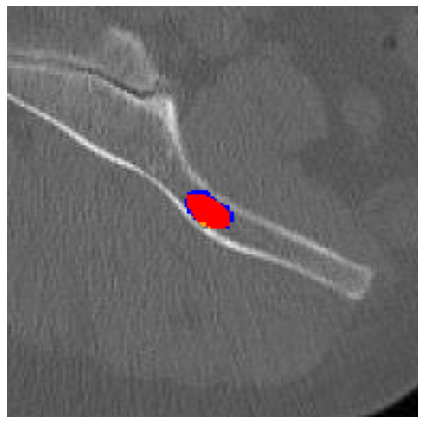

In [121]:
"""
Row: prec < 0.5, prec > 0.5, prec > 0.7
Col: recall < 0.5, recall > 0.5, recall > 0.7
"""
fig, axs = plt.subplots(1, 1 ,figsize = (6, 6))
count_arr = np.zeros((3,3))
axs.set_axis_off()
#[axi.set_axis_off() for axi in axs.ravel()]
fig.tight_layout()
for i, (img, mask) in enumerate(test_ds.as_numpy_iterator()):
    y_pred = threshold_binarize(model.predict(img), 0.5)
    img, mask, y_pred = cv2.cvtColor(np.squeeze(img), cv2.COLOR_GRAY2RGB), cv2.cvtColor(np.squeeze(mask), cv2.COLOR_GRAY2RGB), cv2.cvtColor(np.squeeze(y_pred), cv2.COLOR_GRAY2RGB)
    # Color TP with red
    img[np.logical_and(y_pred == 1.0, mask == 1.0).all(-1)] = [255, 0, 0]
    # Color FP with orange
    img[np.logical_and(y_pred == 1.0, mask == 0.0).all(-1)] = [255, 165, 0]
    # Color FN with blueb
    img[np.logical_and(mask == 1.0, y_pred == 0.0).all(-1)] = [0, 0, 255]
    prec, recall = metrics.prec_recal(mask, y_pred)
    if (prec > 0.7) and (recall > 0.7):
        axs.imshow(np.squeeze(img), cmap = plt.gray())
        break

In [122]:
fig.savefig(Path(ROOT) / "figures/2D_Unet" / "precrecall_colorized_22", format = "png", facecolor = "white", dpi = 300)

Training loop script: python train.py --img-dir '' --mask-dir '' --holdout 1 --weight 'Weights_0.h5' --output-dir 'runs/holdout_1' --device 1 --resume(search output_dir for h5 file)

In [150]:
[ join(IMG_DIR, f"fold_2/crops/lesion/{example_id}{i}.jpg") for i in ['', '2', '3']]

['/wecare/home/khoi/thesis/runs/yolov5/detect/holdout_1/fold_2/crops/lesion/CTP70_001_0197.jpg',
 '/wecare/home/khoi/thesis/runs/yolov5/detect/holdout_1/fold_2/crops/lesion/CTP70_001_01972.jpg',
 '/wecare/home/khoi/thesis/runs/yolov5/detect/holdout_1/fold_2/crops/lesion/CTP70_001_01973.jpg']

In [164]:
holdout = 1
IMG_DIR = str(Path(YOLOV5_DETECT) / f"holdout_{holdout}")
MASK_DIR = str(Path(YOLOV5_DETECT) / f"holdout_{holdout}_true")
example_id = 'CTP22_001_0120'
example_list = [join(IMG_DIR, f"fold_2/crops/lesion/{example_id}.jpg")]
example_ds = Dataset.from_tensor_slices(example_list)
len(example_ds)

1

In [165]:
example_ds = example_ds.map(lambda x: process(MASK_DIR, x), num_parallel_calls=tf.data.AUTOTUNE).batch(1)

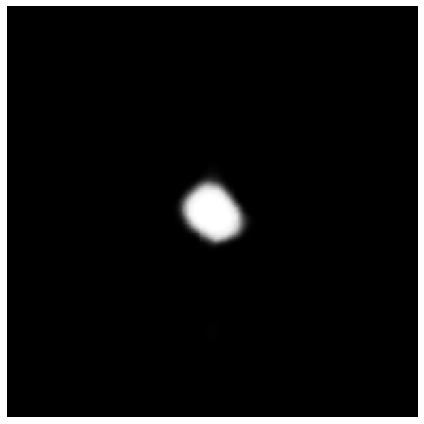

In [175]:
holdout = 1
model = keras.models.load_model(f"runs/holdout_{holdout}/best_model_binEntropy.h5", custom_objects = {"dice_coef" : metrics.dice_coef}, compile = False)

fig, axs = plt.subplots(1,1, figsize = (6, 6))
axs.set_axis_off()
#[axi.set_axis_off() for axi in axs.ravel()]
fig.tight_layout()
for i, (img, mask) in enumerate(example_ds.as_numpy_iterator()):
    if i < 3:
        y_pred = model.predict(img)
        #y_pred = threshold_binarize(y_pred, 0.5)
        #img, mask, y_pred = cv2.cvtColor(np.squeeze(img), cv2.COLOR_GRAY2RGB), cv2.cvtColor(np.squeeze(mask), cv2.COLOR_GRAY2RGB), cv2.cvtColor(np.squeeze(y_pred), cv2.COLOR_GRAY2RGB)
        # Color prediction with red
        #img[(y_pred == 1.0).all(-1)] = [255, 0, 0]
        # Color true mask with blue
        #img[(mask == 1.0).all(-1)] = [0, 0, 255]
        axs.imshow(np.squeeze(y_pred), cmap = plt.gray())
        #axs[i].imsave(Path(ROOT) / "figures/sample_case" / f"seg_examples{i}", format = "png", facecolor = "white", dpi = 300)
        #axs[1,i].imshow(np.squeeze(mask), cmap = plt.gray())

In [176]:
fig.savefig(Path(ROOT) / "figures/sample_case_01" / "prob_map.png", format = "png", facecolor = "white", dpi = 300)

# Evaluation on k folds

In [ ]:
for holdout in [1,2,3,4]:
    IMG_DIR = str(Path(YOLOV5_DETECT) / f"holdout_{holdout}")
    MASK_DIR = str(Path(YOLOV5_DETECT) / f"holdout_{holdout}_true")
    test_ds = Dataset.list_files(join(IMG_DIR, f"fold_{holdout}/crops/lesion/*"))
    test_ds = test_ds.batch(1)
    model = keras.models.load_model(f"runs/holdout_{holdout}/best_model_scratch.h5", custom_objects = {"dice_coef" : metrics.dice_coef}, compile = False)

In [ ]:
model.compile(loss= loss_func, optimizer=optimizer,
                       metrics= metrics)

In [ ]:
model = keras.models.load_model()
y_pred = model.predict(test_ds)
_, y_true
dice_test = dice_coef(y_true)

# Benchmark

In [62]:
import time
BATCH_SIZE = 128
inf_time = np.zeros((5,))
for holdout in tqdm(range(1,6)):
    model = keras.models.load_model(f"runs/holdout_{holdout}/best_model_binEntropy.h5", custom_objects = {"dice_coef" : metrics.dice_coef}, compile = False)
    IMG_DIR = str(Path(YOLOV5_DETECT) / f"holdout_{holdout}")
    MASK_DIR = str(Path(YOLOV5_DETECT) / f"holdout_{holdout}_true")
    test_ds = Dataset.list_files(join(IMG_DIR, f"fold_{holdout}/crops/lesion/*")).map(lambda x: process(MASK_DIR, x), num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE, drop_remainder = True)
    num_batches = len(test_ds)
    batches_time = np.zeros((num_batches,))
    for i, (img, mask) in enumerate(test_ds.as_numpy_iterator()):
        start = time.perf_counter()
        preds = model.predict(img, use_multiprocessing = True)
        end = time.perf_counter()
        batches_time[i] = (end - start) / BATCH_SIZE
    inf_time[holdout - 1] = np.mean(batches_time)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:18<00:00,  3.72s/it]


In [64]:
np.mean(inf_time)

0.0009956095562695486

In [61]:
model = keras.models.load_model(f"runs/holdout_1/best_model_binEntropy.h5", custom_objects = {"dice_coef" : metrics.dice_coef}, compile = False)
IMG_DIR = str(Path(YOLOV5_DETECT) / f"holdout_1")
MASK_DIR = str(Path(YOLOV5_DETECT) / f"holdout_1_true")
test_ds = Dataset.list_files(join(IMG_DIR, f"fold_1/crops/lesion/*")).map(lambda x: process(MASK_DIR, x)).batch(128)
for i, (img, mask) in enumerate(test_ds.as_numpy_iterator()):
    if i < 5:
        start = time.perf_counter()
        preds = model.predict(img)
        end = time.perf_counter()
        print((end - start) / 128)

0.0022627998696407303
0.0009812466269067954
0.0009518108272459358
0.0009784315298020374
0.0008616402192274109


# Create demo video

In [9]:
import re
import skvideo
skvideo.setFFmpegPath("/wecare/home/khoi/Downloads/ffmpeg-5.0.1-amd64-static")
import skvideo.io

In [5]:
holdout = 1
DEMO_DIR = Path(ROOT) / "demo/2D_Unet/"
model = keras.models.load_model(f"runs/holdout_{holdout}/best_model_binEntropy.h5", custom_objects = {"dice_coef" : metrics.dice_coef}, compile = False)
IMG_DIR = str(Path(YOLOV5_DETECT) / f"holdout_{holdout}")
MASK_DIR = str(Path(YOLOV5_DETECT) / f"holdout_{holdout}_true")
CROPS_DIR = join(YOLOV5_DETECT, "holdout_1/fold_4/crops/lesion/")

In [47]:
crops_abs_paths = sorted([join(CROPS_DIR, f) for f in os.listdir(CROPS_DIR) if re.search(f"CTP10_001_0[1-2][0-9][0-9][0-9]*.jpg" ,f)])
crops_abs_paths[:3], len(crops_abs_paths)

(['/wecare/home/khoi/thesis/runs/yolov5/detect/holdout_1/fold_4/crops/lesion/CTP10_001_0100.jpg',
  '/wecare/home/khoi/thesis/runs/yolov5/detect/holdout_1/fold_4/crops/lesion/CTP10_001_0101.jpg',
  '/wecare/home/khoi/thesis/runs/yolov5/detect/holdout_1/fold_4/crops/lesion/CTP10_001_0102.jpg'],
 73)

In [48]:
demo_ds = Dataset.from_tensor_slices(crops_abs_paths).map(lambda x: process(MASK_DIR, x)).batch(1)

In [49]:
video_arr = np.zeros((73, 192, 192, 3))
for i, (img, mask) in enumerate(demo_ds.as_numpy_iterator()):
    pred = threshold_binarize(model.predict(img), 0.5)
    #print(img.shape)
    img_converted, pred_converted = cv2.cvtColor(np.squeeze(img), cv2.COLOR_GRAY2RGB), cv2.cvtColor(np.squeeze(pred), cv2.COLOR_GRAY2RGB)
    img_converted[(pred_converted == 1.0).all(-1)] = [255,0,0]
    video_arr[i, ...] = img_converted
    #print(img_converted.shape)

In [50]:
skvideo.io.vwrite(join(ROOT, "demo/2D_Unet/crops_segmented_v1.mp4"), video_arr)